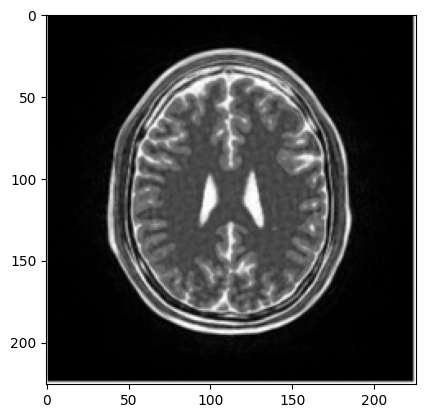

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch
import numpy as np
import os, time, random
import argparse
from math import log10
from torch.utils.data import Dataset, DataLoader
from PIL import Image as PILImage
from model.model import InvISPNet
# from dataset.mri_dataset import mriDataset, mriDataset12, mriDataset12_real_imag, mriDataset12_real_imag_cross
from dataset.mri_dataset_weight import mriDataset_real_imag_cross
from config.config import get_arguments
from utils.commons import denorm, preprocess_test_patch
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from scipy.io import savemat, loadmat
import os.path as osp
import cv2
import scipy.io as io
from matplotlib import pyplot as plt

# os.environ['CUDA_VISIBLE_DEVICES'] = "1"
channel_ONE = 2
channel_TWO = 2
bs = channel_ONE // channel_TWO
channel_in = int(channel_ONE * 2)
channel_last = int(channel_TWO * 2)
modelNum = 'latest'

parser = get_arguments()
parser.add_argument("--ckpt", type=str, default=f'./exps/{channel_ONE}to{channel_TWO}/checkpoint/{modelNum}.pth',
                    help="Checkpoint path.")
parser.add_argument("--out_path", type=str, default="./exps/", help="Path to save results. ")
parser.add_argument("--task", type=str, default=f"test")
parser.add_argument("--split_to_patch", dest='split_to_patch', action='store_true', help="Test on patch. ")
args = parser.parse_args()

def write_images(x,image_save_path):
    x = np.clip(x *255 , 0, 255).astype(np.uint8)
    cv2.imwrite(image_save_path, x)

def wgt2k(X,W,DC):
    Y = np.multiply(X,1./W)
    Y[W == 0] = DC[W == 0]
    return Y

def complex_abs_eval(data):
    assert data.size(1) == 2
    return (data[:, 0:1, :, :] ** 2 + data[:, 1:2, :, :] ** 2).sqrt()

def psnr(sr_image, gt_image):
    # assert sr_image.size(0) == gt_image.size(0) == 1

    peak_signal = (gt_image.max() - gt_image.min()).item()

    mse = (sr_image - gt_image).pow(2).mean().item()

    return 10 * log10(peak_signal ** 2 / mse)

def get_next_net(input_channel4_mri_real_imag,reconstruct_4_real_imag):

    input_channel4_mri = torch.zeros(reconstruct_4_real_imag.size()).cuda()
    input_channel4_mri[:, 0:1, :, :] = input_channel4_mri_real_imag[:, 0:1, :, :]
    aa = torch.zeros(1, 2, 256, 256).cuda()
    aa[:, 0, :, :] = reconstruct_4_real_imag[:, 0, :, :]
    aa[:, 1, :, :] = reconstruct_4_real_imag[:, 2, :, :]
    aa_mean = torch.mean(aa, dim=1, keepdim=True)
    input_channel4_mri[:, 2, :, :] = aa_mean
    aa[:, 0, :, :] = reconstruct_4_real_imag[:, 1, :, :]
    aa[:, 1, :, :] = reconstruct_4_real_imag[:, 3, :, :]
    aa_mean = torch.mean(aa, dim=1, keepdim=True)
    input_channel4_mri[:, 3, :, :] = aa_mean

    return input_channel4_mri

ckpt_name = args.ckpt.split("/")[-1].split(".")[0]
if args.split_to_patch:
    os.makedirs(args.out_path + "%s/results_metric_%s/" % (args.task, ckpt_name), exist_ok=True)
    out_path = args.out_path + "%s/results_metric_%s/" % (args.task, ckpt_name)
else:
    os.makedirs(args.out_path + "%s/results_%s/" % (args.task, ckpt_name), exist_ok=True)
    out_path = args.out_path + "%s/results_%s/" % (args.task, ckpt_name)


def main(args):
    net = InvISPNet(channel_in=channel_in, channel_out=channel_in, block_num=8)

    device = torch.device("cuda:0")

    net.to(device)
    net.eval()

    if os.path.isfile(args.ckpt):
        net.load_state_dict(torch.load(args.ckpt), strict=False)
        print("[INFO] Loaded checkpoint: {}".format(args.ckpt))

    print("[INFO] Start data load and preprocessing")

    mri_dataset = mriDataset_real_imag_cross(
        # root1='/zw/data/sampled',
        # root2='/zw/data/Test',
        # root='/zw/data/sampled')
        # root1='/zw/data_sait/T1_test',
        # root1='/zw/data_sait/T1_test',
        # root2='/zw/data_sait/T2_test',
        # root='/zw/data/mask/radial/40.mat')
        root1='/zw/data/zh/T1_test',
        root2='/zw/data/zh/T2_test',
        # root1='/zw/results_2to2/input',
        # root2='/zw/results_2to2/for',
        root='/zw/data/mask/radial/20.mat')
        # root='/zw/data/mask/mask_cartR3.mat')
        # root = '/zw/data/mask/radial/20.mat')
        # root='/zw/mask_random/random2D_20.mat')
    dataloader = DataLoader(mri_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=True)

    print("[INFO] Start test...")
    PSNR_zero = []
    SSIM_zero = []
    PSNR_COMPRESS = []
    SSIM_COMPRESS = []
    for i_batch, sample_batched in enumerate(dataloader):
        iiii = i_batch + 1
        step_time = time.time()

        weight = loadmat('/zw/data/weight/weight_0.5_1e2.mat')['weight']

        # the two thing are same
        # +weight
        input_channel4_mri_real_imag = sample_batched['input_channel4_T12_mri_w'].to(device)
        target_channel4_mri_real_imag = sample_batched['target_channel4_T2_mri_w'].to(device)

        # input_channel4_mri_real_imag[:,0,:,:] = input_channel4_mri_real_imag[:,2,:,:]
        # input_channel4_mri_real_imag[:, 1, :, :] = input_channel4_mri_real_imag[:,3,:,:]
        
        plt.imshow(ori, cmap='gray')
        plt.show()
       

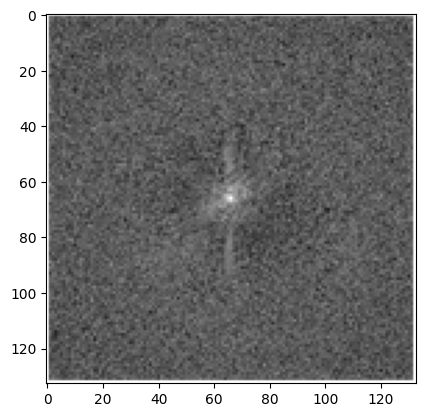

In [4]:
 with torch.no_grad():
            reconstruct_4_real_imag = net(input_channel4_mri_real_imag)


        pred_4_real_imag = reconstruct_4_real_imag.detach().permute(0, 2, 3, 1).squeeze()
        input_channel4_mri_real_imag = input_channel4_mri_real_imag.detach().permute(0, 2, 3, 1).squeeze()
        target_channel4_mri_real_imag = target_channel4_mri_real_imag.detach().permute(0, 2, 3, 1).squeeze()

        pred_4_real_imag = pred_4_real_imag.cpu().numpy()
        # input_channel4_mri_real_imag = input_channel4_mri_real_imag.cpu().numpy()
        # target_channel4_mri_real_imag = target_channel4_mri_real_imag.cpu().numpy()
        target = target.cpu().numpy().squeeze()
        input = input.cpu().numpy().squeeze()


        # input
        input_2coil_complex = np.zeros([256, 256, channel_ONE], dtype=np.complex64)
        for i in range(0, channel_in, 2):
            input_2coil_complex[:, :, int(i / 2)] = input[:, :,i] + 1j * input[:, :, i + 1]

        input_2coil_complex_img = np.zeros(input_2coil_complex.shape, dtype=np.complex64)
        for i in range(input_2coil_complex.shape[-1]):
            input_2coil_complex_img[:, :, i] = np.fft.ifft2(np.fft.ifftshift(input_2coil_complex[:, :, i]))

        # get T2 sampled

        input_2coil_complex_img_sos = input_2coil_complex_img[:, :, 1]
        # input_2coil_complex_img_sos = input_2coil_complex_img[38: 219, 25: 243,1]

        path_root = f'./results_{channel_ONE}to{channel_TWO}'
        path_list = [f'{path_root}/input', f'{path_root}/ori', f'{path_root}/for']
        for kk in path_list:
            if not os.path.isdir(kk):
                os.makedirs(kk)

        savemat(f'{path_list[0]}/{iiii}.mat', {'data': input_2coil_complex_img[:,:,1]})

        # ori
        ori_complex = np.zeros([256, 256, channel_ONE], dtype=np.complex64)
        for i in range(0, channel_in, 2):
            ori_complex[:, :, int(i / 2)] = target[:, :,i] + 1j * target[:, :, i + 1]
            
        plt.imshow(kspace, cmap='gray')
        plt.show()


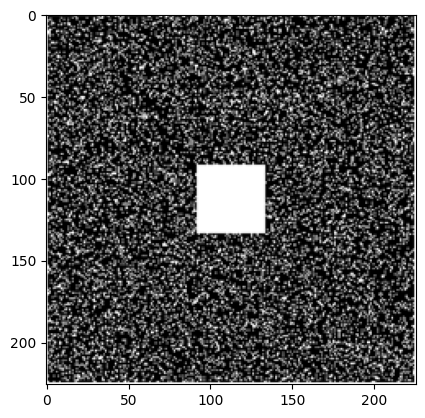

In [5]:
 # ori data
        input = sample_batched['input_channel4_T12_mri'].to(device)
        target = sample_batched['target_channel4_T2_mri'].to(device)
        mask_dc = sample_batched['mask_dc']
        mask_dc = mask_dc.cpu().numpy().squeeze()
        plt.imshow(mask, cmap='gray')
        plt.show()


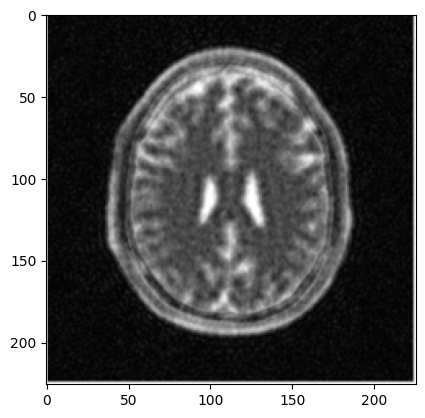

In [6]:
        # kspace to image
        pred_2_complex_img = np.zeros(pred_2_complex_nw.shape, dtype=np.complex64)
        for i in range(pred_2_complex_nw.shape[-1]):
            pred_2_complex_img[:, :, i] = np.fft.ifft2(np.fft.ifftshift(k_complex2[:, :, i]))
        print(iiii)
        pred_2_complex_sos = np.mean(pred_2_complex_img, axis=2)
        savemat(f'{path_list[2]}/{iiii}.mat', {'data': pred_2_complex_sos})
        # pred_2_complex_sos = pred_2_complex_sos_0[38: 219, 25: 243]


        ori_complex_sos = ori_complex_sos / np.max(abs(ori_complex_sos))
        # print(ori_complex_sos[128,128])
        pred_2_complex_sos = pred_2_complex_sos / np.max(abs(pred_2_complex_sos))
        # print(pred_2_complex_sos[128, 128])
        input_2coil_complex_img_sos = input_2coil_complex_img_sos / np.max(abs(input_2coil_complex_img_sos))
        # print(input_2coil_complex_img_sos[128, 128])
        # aa = ori_complex_sos
        # ori_complex_sos = ori_complex_sos / np.max(abs(aa))
        # pred_2_complex_sos = pred_2_complex_sos / np.max(abs(aa))
        # input_2coil_complex_img_sos = input_2coil_complex_img_sos / np.max(abs(aa))

        ## zero_psnr and ssim
        psnr_compress_zero = compare_psnr(255 * abs(ori_complex_sos), 255 * abs(input_2coil_complex_img_sos), data_range=255)
        ssim_compress_zero = compare_ssim(abs(ori_complex_sos), abs(input_2coil_complex_img_sos), data_range=1)
        # psnr_compress_zero = psnr(input_2coil_complex_img_sos,ori_complex_sos)
        plt.imshow(zerosfilled, cmap='gray')
        plt.show()


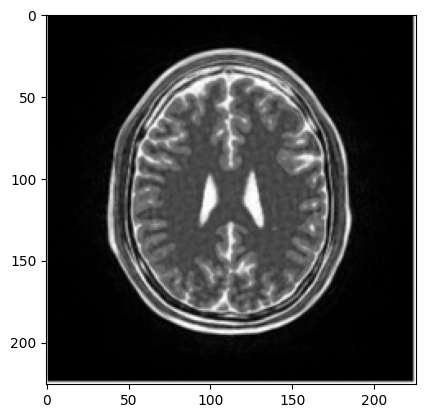

In [7]:
 psnr_compress = compare_psnr(255 * abs(ori_complex_sos), 255 * abs(pred_2_complex_sos), data_range=255)
        ssim_compress = compare_ssim(abs(ori_complex_sos), abs(pred_2_complex_sos), data_range=1)

        write_images(abs(ori_complex_sos), osp.join('./results/' + 'target' + '.png'))
        write_images(abs(input_2coil_complex_img_sos), osp.join('./results/' + 'input' + '.png'))
        write_images(abs(pred_2_complex_sos), osp.join('./results/' + 'pred' + '.png'))

        # print('psnr_forward:',psnr_compress,'    ssim_forward:',ssim_compress)
        PSNR_COMPRESS.append(psnr_compress)
        SSIM_COMPRESS.append(ssim_compress)
        PSNR_zero.append(psnr_compress_zero)
        SSIM_zero.append(ssim_compress_zero)

        del reconstruct_4_real_imag
    ave_psnr_compress = sum(PSNR_COMPRESS) / len(PSNR_COMPRESS)
    ave_ssim_compress = sum(SSIM_COMPRESS) / len(SSIM_COMPRESS)
    ave_psnr_zero = sum(PSNR_zero) / len(PSNR_zero)
    ave_ssim_zero = sum(SSIM_zero) / len(SSIM_zero)
    print("ave_psnr_forward: %.10f || ave_ssim_forward:%.10f" % (ave_psnr_compress, ave_ssim_compress))
    print("ave_psnr_zero: %.10f || ave_ssim_zero:%.10f" % (ave_psnr_zero, ave_ssim_zero))
    plt.imshow(rec, cmap='gray')
    plt.show()